Creating txt files  

In [5]:
import os
import random

from IPython.core.pylabtools import figsize
from PIL.ImageColor import colormap
from faker import Faker
from sklearn.metrics import accuracy_score


def generate_random_text(size, language = 'en'):
    fake = Faker(language)
    words = []
    while sum(len(w) for w in words) + len(words) - 1 < size:
        words.append(fake.word())
        
    return ' '.join(words)[:size]

def create_txt_files(num_of_files = 1000, min_size = 300, max_size = 10000, output_dir = 'generated_txts_1000', language = 'en'):
    os.makedirs(output_dir, exist_ok=True)
    
    for i in range(1, num_of_files + 1):
        size = random.randint(min_size, max_size)
        text = generate_random_text(size, language) 
        filename = os.path.join(output_dir, f'file{i:04d}.txt')
        
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(text)
            
    print(f"Generated {num_of_files} files. Saved in directory '{output_dir}'")
    
create_txt_files()

Generated 1000 files. Saved in directory 'generated_txts'


Encryption of 1000 txt files with AES, DES, 3DES, RC4 in ECB mode

In [6]:
import os
from Crypto.Cipher import AES, DES, DES3, ARC4
from Crypto.Util.Padding import pad
from Crypto.Random import get_random_bytes

def encrypt_ecb(algorithm, key, plaintext):
    if algorithm == 'AES':
        cipher = AES.new(key, AES.MODE_ECB)
        return cipher.encrypt(pad(plaintext, AES.block_size))
    elif algorithm == 'DES':
        cipher = DES.new(key, DES.MODE_ECB)
        return cipher.encrypt(pad(plaintext, DES.block_size))
    elif algorithm == 'DES3':
        cipher = DES3.new(key, DES.MODE_ECB)
        return cipher.encrypt(pad(plaintext, DES3.block_size))
    elif algorithm == 'ARC4':
        cipher = ARC4.new(key)
        return cipher.encrypt(plaintext)

def encrypt_file_ecb(input_dir='generated_txts_1000', output_dir='encrypted_txts_1000_ecb'):
    os.makedirs(output_dir, exist_ok=True)

    algorithms = {
        'AES': 30,
        'DES': 25,
        'DES3': 20,
        'ARC4': 15,
        'NONE': 10
    }

    keys = {
        'AES': get_random_bytes(16),
        'DES': get_random_bytes(8),
        'DES3': DES3.adjust_key_parity(get_random_bytes(24)),
        'ARC4': get_random_bytes(16),
    }

    file_list = sorted(os.listdir(input_dir))   
    total_files = len(file_list)
    assigned_files = 0

    for algo, percentage in algorithms.items():
        algo_count = int((percentage / 100) * total_files)
        algo_dir = os.path.join(output_dir, algo) 
        os.makedirs(algo_dir, exist_ok=True)

        for _ in range(algo_count):
            if assigned_files >= total_files:
                break
            file_name = file_list[assigned_files]
            input_path = os.path.join(input_dir, file_name)
            output_path = os.path.join(algo_dir, file_name + '.enc')  

            if os.path.isdir(input_path):  
                continue  

            with open(input_path, 'rb') as f:
                plain_text = f.read()
                if algo != 'NONE':
                    cipher_text = encrypt_ecb(algo, keys[algo], plain_text)
                    with open(output_path, 'wb') as f_encrypted:
                        f_encrypted.write(cipher_text)
                else:
                    os.rename(input_path, os.path.join(algo_dir, file_name))

            assigned_files += 1

    print(f"Encrypted all files. Saved in directory '{output_dir}'")

encrypt_file_ecb()


Encrypted all files. Saved in directory 'encrypted_txts_ecb'


In [8]:
aes_len = len(os.listdir('encrypted_txts_1000_ecb/AES'))
arc4_len = len(os.listdir('encrypted_txts_1000_ecb/ARC4'))
des_len = len(os.listdir('encrypted_txts_1000_ecb/DES'))
des3_len = len(os.listdir('encrypted_txts_1000_ecb/DES3'))
none_len = len(os.listdir('encrypted_txts_1000_ecb/NONE'))

print(f"{aes_len} AES Files")
print(f"{arc4_len} ARC4 Files")
print(f"{des3_len} 3DES Files")
print(f"{des_len} DES Files")
print(f"{none_len} NONE")

300 AES Files
150 ARC4 Files
200 3DES Files
250 DES Files
100 NONE


Create dataframe based on encrypted files with pandas 

In [3]:
import pandas as pd
import numpy as np
import scipy 
from collections import Counter
from math import log2
import os

def calculate_entropy(byte_data):
    if len(byte_data) == 0:  
        return 0
    counts = Counter(byte_data)
    length = len(byte_data)
    return -sum((freq / length) * log2(freq / length) for freq in counts.values())


def extract_values(file_path):
    with open(file_path, 'rb') as f:
        byte_data = f.read()
    
    if not byte_data:
        return None
    
    byte_array = np.frombuffer(byte_data, dtype=np.uint8)
    
    entropy = calculate_entropy(byte_array)
    mean = np.mean(byte_array)
    variance = np.var(byte_array)
    std_dev = np.std(byte_array)
    skewness = scipy.stats.skew(byte_array)
    kurtosis = scipy.stats.kurtosis(byte_array)
    energy = np.sum(byte_array ** 2)
    rms = np.sqrt(np.mean(byte_array  ** 2))
    
    hist, _ = np.histogram(byte_array, bins=256, range=(0, 256))
    
    return [entropy, mean, variance, std_dev, skewness, kurtosis, energy, rms] + hist.tolist()

def process_encrypted_files(input_dir, output_csv):
    data = []
    
    for algo in os.listdir(input_dir):
        algo_dir = os.path.join(input_dir, algo)
        if not os.path.isdir(algo_dir):
            continue
            
        for file_name in os.listdir(algo_dir):
            file_path = os.path.join(algo_dir, file_name)
            features = extract_values(file_path)
            if features:
                data.append([file_name] + features + [algo])
                
    columns = [
        "file_name", "entropy", "mean", "variance", "std_dev", "skewness", "kurtosis", "energy", "rms"
    ] + [f"histogram_{i}" for i in range(256)] + ["algorithm"]
    
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(output_csv, index=False)
    print(f"Saved extracted features to {output_csv}")
    
input_directory = 'encrypted_txts_1000_ecb'
output_csv = 'encrypted_features_txt_1000_ecb.csv'
process_encrypted_files(input_directory, output_csv)

Saved extracted features to encrypted_features_txt_ecb.csv


In [2]:
import pandas as pd

df = pd.read_csv('encrypted_features_txt_1000_ecb.csv')
df

,file_name,entropy,mean,variance,std_dev,skewness,kurtosis,energy,rms,histogram_0,...,histogram_247,histogram_248,histogram_249,histogram_250,histogram_251,histogram_252,histogram_253,histogram_254,histogram_255,algorithm
0,file0359.txt.enc,7.976844,128.101334,5314.339758,72.899518,-0.013909,-1.170626,813877,10.315860,26,...,27,31,26,34,32,24,26,32,23,DES
1,file0349.txt.enc,7.955156,125.180851,5527.607718,74.347883,0.026588,-1.200481,390520,10.191256,20,...,11,12,13,15,14,12,13,12,13,DES
2,file0474.txt.enc,7.952942,127.240346,5606.797417,74.878551,-0.001756,-1.229536,411234,10.221555,15,...,9,9,12,13,23,24,15,15,20,DES
3,file0464.txt.enc,7.853888,127.697794,5366.093230,73.253623,0.032639,-1.169655,145371,10.338783,5,...,6,9,5,5,3,4,5,8,8,DES
4,file0416.txt.enc,7.975566,128.614079,5412.677394,73.570900,-0.015208,-1.205074,892243,10.291588,27,...,29,34,29,24,40,33,32,33,34,DES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,file0058.txt.enc,7.958384,126.755736,5504.073049,74.189440,0.006378,-1.212936,542725,10.360635,19,...,9,25,25,21,21,18,18,24,16,AES
996,file0256.txt.enc,7.947136,127.766628,5426.144506,73.662368,-0.005166,-1.182701,366838,10.255313,14,...,14,13,12,13,22,10,10,17,8,AES
997,file0246.txt.enc,7.940557,127.018076,5497.270200,74.143578,-0.001508,-1.230272,352381,10.390374,10,...,20,8,11,7,15,11,11,11,10,AES
998,file0189.txt.enc,7.852501,127.194522,5540.121571,74.431993,0.016029,-1.215906,150665,10.286111,7,...,5,3,10,7,5,7,8,2,3,AES


Comparison of histograms by encryption algorithms

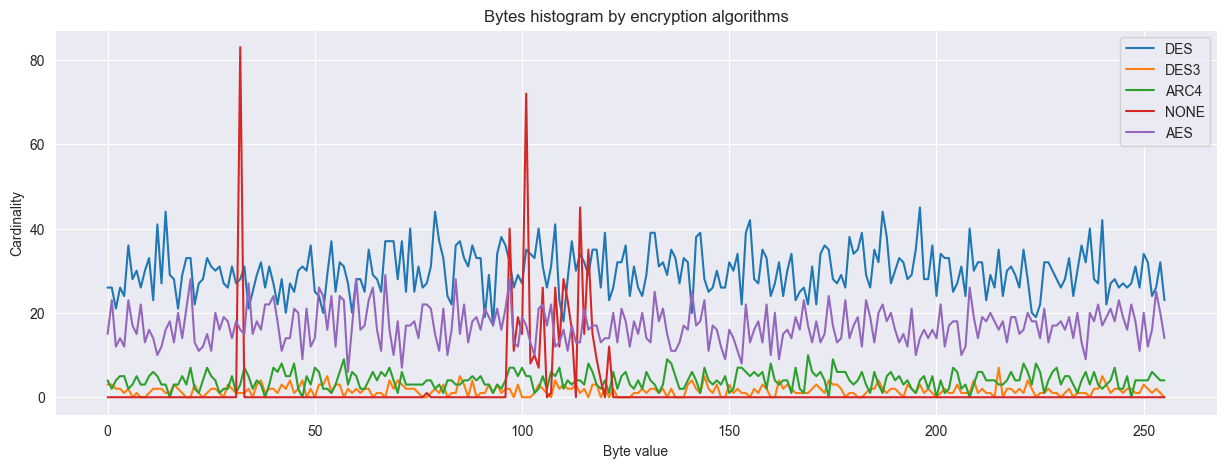

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
for i, algo in enumerate(df["algorithm"].unique()):
    subset = df[df["algorithm"] == algo].iloc[0, 9:265]  # Kolumny histogramu
    plt.plot(range(256), subset, label=algo)

plt.legend()
plt.title("Bytes histogram by encryption algorithms")
plt.xlabel("Byte value")
plt.ylabel("Cardinality")
plt.show()

Entropy in ECB mode by encryption algorithms 

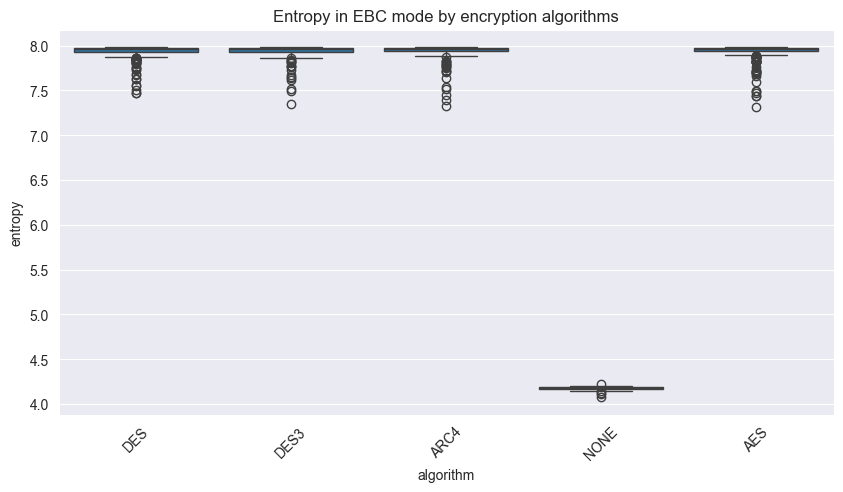

In [4]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.boxplot(x=df["algorithm"], y=df["entropy"])
plt.xticks(rotation=45)
plt.title("Entropy in EBC mode by encryption algorithms")
plt.show()


Data preprocessing before cross-validation

In [5]:
import pandas as pd

data_frame = pd.read_csv('encrypted_features_txt_1000_ecb.csv')
data_frame

,file_name,entropy,mean,variance,std_dev,skewness,kurtosis,energy,rms,histogram_0,...,histogram_247,histogram_248,histogram_249,histogram_250,histogram_251,histogram_252,histogram_253,histogram_254,histogram_255,algorithm
0,file0359.txt.enc,7.976844,128.101334,5314.339758,72.899518,-0.013909,-1.170626,813877,10.315860,26,...,27,31,26,34,32,24,26,32,23,DES
1,file0349.txt.enc,7.955156,125.180851,5527.607718,74.347883,0.026588,-1.200481,390520,10.191256,20,...,11,12,13,15,14,12,13,12,13,DES
2,file0474.txt.enc,7.952942,127.240346,5606.797417,74.878551,-0.001756,-1.229536,411234,10.221555,15,...,9,9,12,13,23,24,15,15,20,DES
3,file0464.txt.enc,7.853888,127.697794,5366.093230,73.253623,0.032639,-1.169655,145371,10.338783,5,...,6,9,5,5,3,4,5,8,8,DES
4,file0416.txt.enc,7.975566,128.614079,5412.677394,73.570900,-0.015208,-1.205074,892243,10.291588,27,...,29,34,29,24,40,33,32,33,34,DES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,file0058.txt.enc,7.958384,126.755736,5504.073049,74.189440,0.006378,-1.212936,542725,10.360635,19,...,9,25,25,21,21,18,18,24,16,AES
996,file0256.txt.enc,7.947136,127.766628,5426.144506,73.662368,-0.005166,-1.182701,366838,10.255313,14,...,14,13,12,13,22,10,10,17,8,AES
997,file0246.txt.enc,7.940557,127.018076,5497.270200,74.143578,-0.001508,-1.230272,352381,10.390374,10,...,20,8,11,7,15,11,11,11,10,AES
998,file0189.txt.enc,7.852501,127.194522,5540.121571,74.431993,0.016029,-1.215906,150665,10.286111,7,...,5,3,10,7,5,7,8,2,3,AES


Converting algorithm labels to numeric values

In [6]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data_frame['algorithm'] = encoder.fit_transform(data_frame['algorithm'])
print(encoder.classes_)

['AES' 'ARC4' 'DES' 'DES3' 'NONE']


Data normalization with MinMaxScaler

In [7]:
from sklearn.preprocessing import MinMaxScaler

X = data_frame.drop(columns=["algorithm", "file_name"])
y = data_frame["algorithm"]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Model training and cross validation - StratifiedKFold

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    log_loss, roc_auc_score
)

models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="linear", probability=True),
    "NaiveBayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Bagging": BaggingClassifier(n_estimators=50, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_list = []
class_results = {model_name: [] for model_name in models}

for model_name, model in models.items():
    acc_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
    log_losses, auc_scores = [], []
    
    for train_index, test_index in skf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]  # dla pandas.DataFrame
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

        acc_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

        if y_pred_proba is not None:
            log_losses.append(log_loss(y_test, y_pred_proba))
            auc_scores.append(roc_auc_score(y_test, y_pred_proba, multi_class="ovr"))
        else:
            log_losses.append(None)
            auc_scores.append(None)

        class_precision = precision_score(y_test, y_pred, average=None)
        class_recall = recall_score(y_test, y_pred, average=None)
        class_f1 = f1_score(y_test, y_pred, average=None)

        for i, class_label in enumerate(np.unique(y)):
            class_results[model_name].append({
                "Class": class_label,
                "Precision": class_precision[i],
                "Recall": class_recall[i],
                "F1-Score": class_f1[i]
            })

    results_list.append({
        "Model": model_name,
        "Accuracy Mean": np.mean(acc_scores),
        "Accuracy Std": np.std(acc_scores),
        "Precision Mean": np.mean(precision_scores),
        "Precision Std": np.std(precision_scores),
        "Recall Mean": np.mean(recall_scores),
        "Recall Std": np.std(recall_scores),
        "F1-Score Mean": np.mean(f1_scores),
        "F1-Score Std": np.std(f1_scores),
        "Log Loss Mean": np.mean([x for x in log_losses if x is not None]) if any(log_losses) else None,
        "AUC Mean": np.mean([x for x in auc_scores if x is not None]) if any(auc_scores) else None
    })

# Konwersja wyników do DataFrame
df_results = pd.DataFrame(results_list)
df_class_results = pd.DataFrame([
    {"Model": model, **result} for model, results in class_results.items() for result in results
])

# Wyświetlenie tabeli w Jupyter Notebook
df_results.style.format("{:.4f}"), df_class_results.style.format("{:.4f}")


(<pandas.io.formats.style.Styler at 0x17dd304c0>,
 <pandas.io.formats.style.Styler at 0x17bc8e250>)

In [9]:
df_results

,Model,Accuracy Mean,Accuracy Std,Precision Mean,Precision Std,Recall Mean,Recall Std,F1-Score Mean,F1-Score Std,Log Loss Mean,AUC Mean
0,RandomForest,0.513,0.021817,0.500856,0.027411,0.513,0.021817,0.482589,0.022371,1.075566,0.805339
1,SVM,0.698,0.035721,0.724920,0.026520,0.698,0.035721,0.699411,0.035903,0.677230,0.923058
2,NaiveBayes,0.415,0.034928,0.439865,0.049367,0.415,0.034928,0.395313,0.037855,6.570829,0.722409
3,KNN,0.496,0.024980,0.500210,0.036846,0.496,0.024980,0.481159,0.029042,4.361857,0.779087
4,Bagging,0.490,0.021213,0.491114,0.032609,0.490,0.021213,0.471325,0.026176,1.280250,0.784597
5,AdaBoost,0.431,0.022226,0.428070,0.025610,0.431,0.022226,0.418077,0.018490,1.584337,0.759801


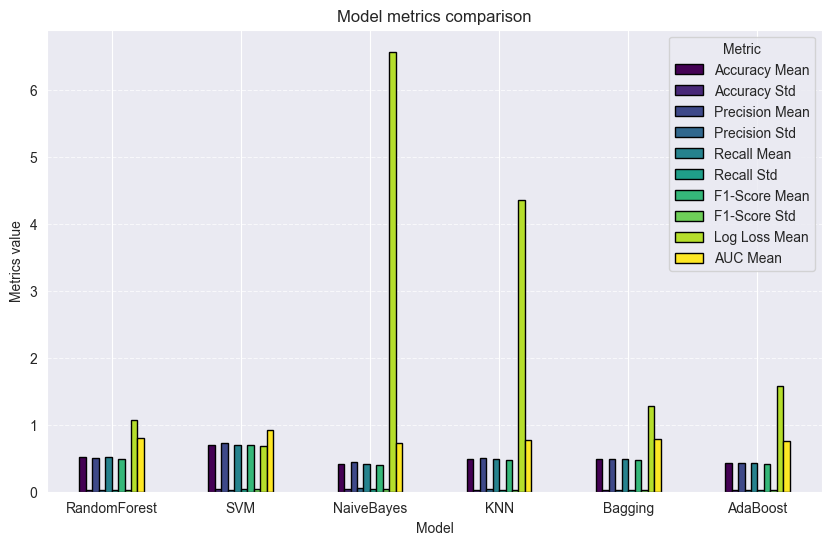

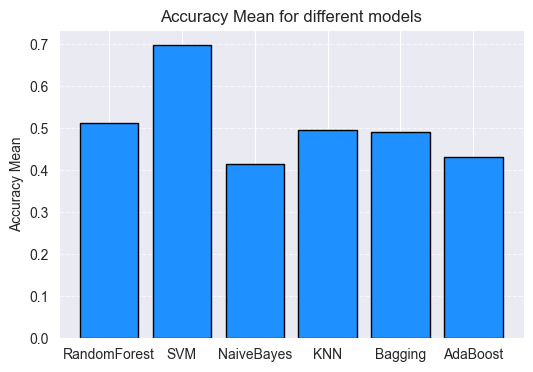

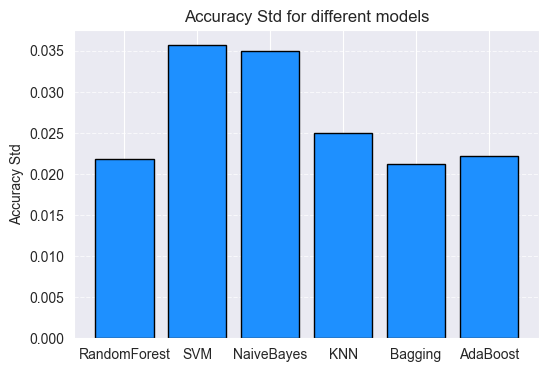

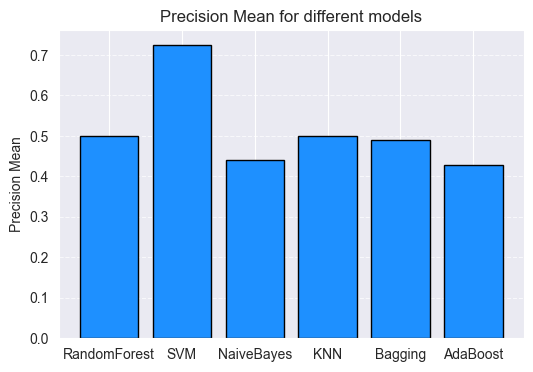

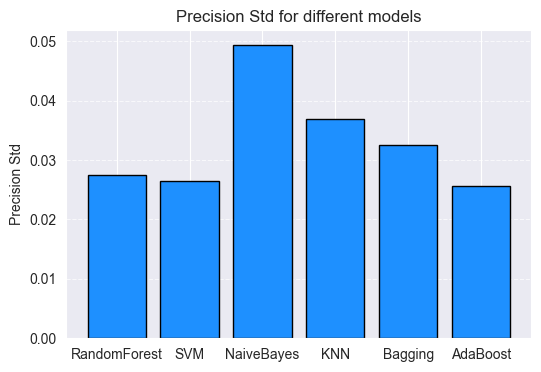

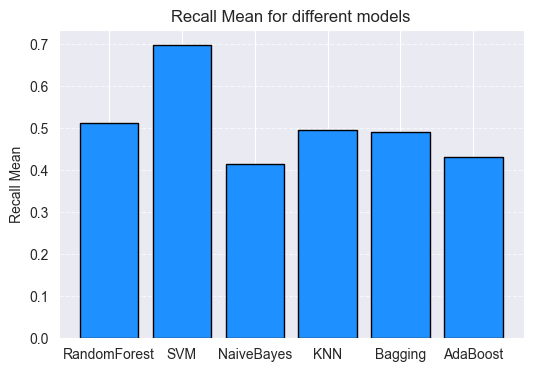

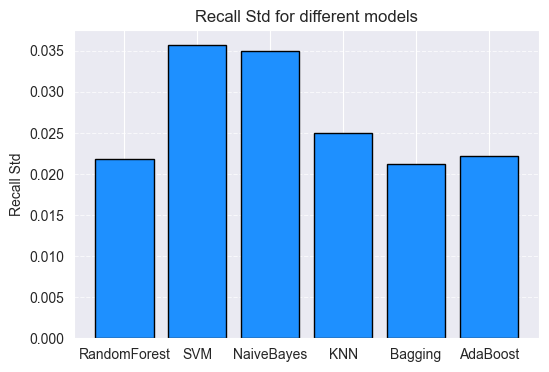

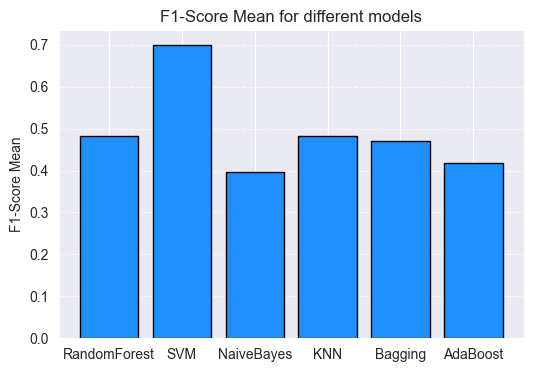

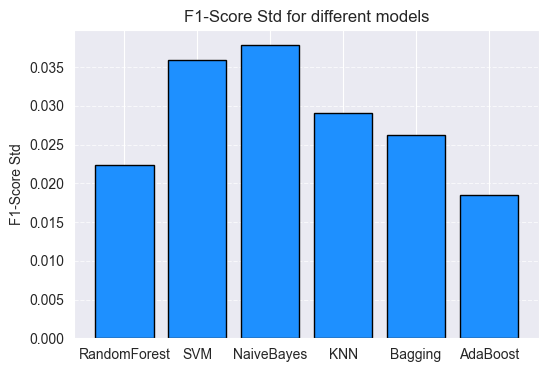

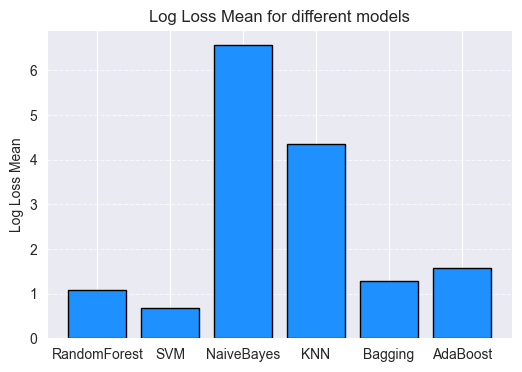

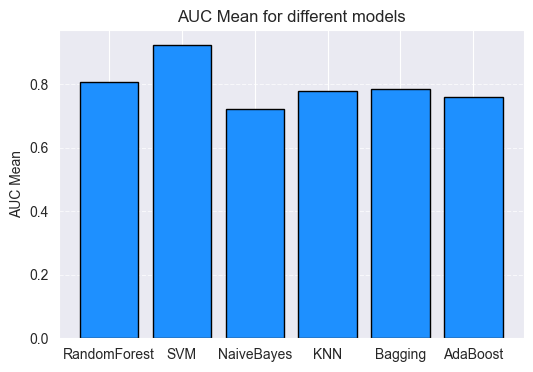

In [10]:
df_results.set_index("Model").plot(kind="bar", figsize=(10,6), colormap="viridis", edgecolor="black")
plt.title("Model metrics comparison")
plt.ylabel("Metrics value")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

for metric in df_results.columns[1:]:
    plt.figure(figsize=(6,4))
    plt.bar(df_results["Model"], df_results[metric], color="dodgerblue", edgecolor="black")
    plt.title(f"{metric} for different models")
    plt.ylabel(metric)
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

In [11]:
df_class_results

,Model,Class,Precision,Recall,F1-Score
0,RandomForest,0,0.393939,0.650000,0.490566
1,RandomForest,1,0.550000,0.366667,0.440000
2,RandomForest,2,0.431373,0.440000,0.435644
3,RandomForest,3,0.200000,0.050000,0.080000
4,RandomForest,4,1.000000,1.000000,1.000000
5,RandomForest,0,0.422680,0.683333,0.522293
6,RandomForest,1,0.656250,0.700000,0.677419
7,RandomForest,2,0.486486,0.360000,0.413793
8,RandomForest,3,0.285714,0.100000,0.148148
9,RandomForest,4,1.000000,1.000000,1.000000


Best model: SVM with F1-Score = 0.7471081919900746
Worst model: NaiveBayes with F1-Score = 0.44903914946313095


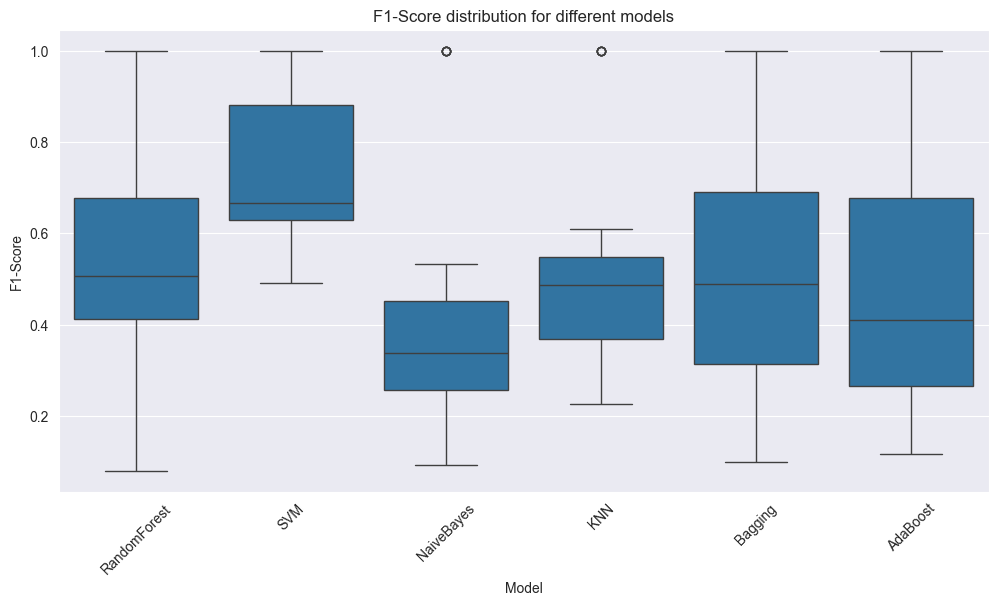

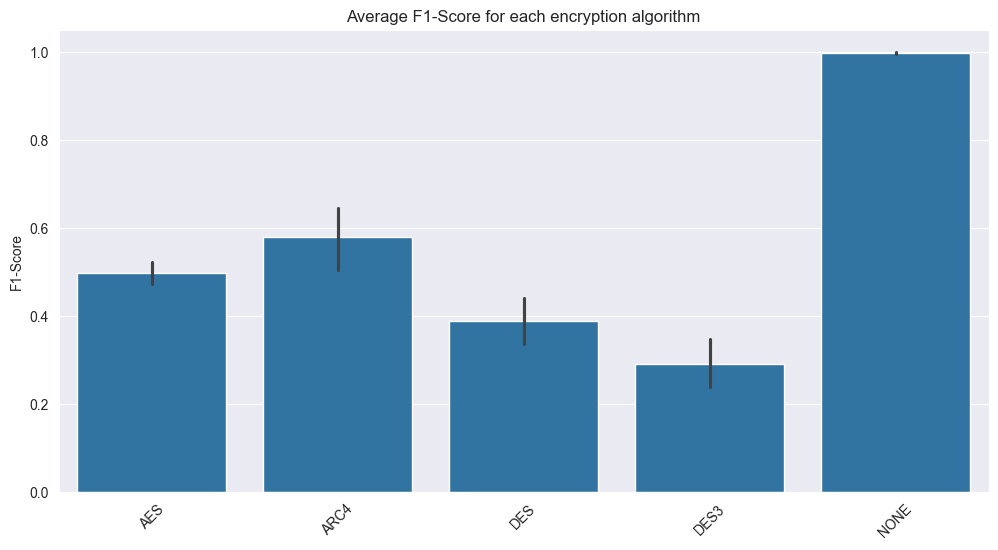

In [18]:
model_scores = df_class_results.groupby("Model")["F1-Score"].mean().sort_values(ascending=False)

best_model = model_scores.idxmax()
worst_model = model_scores.idxmin()
print(f"Best model: {best_model} with F1-Score = {model_scores.max()}")
print(f"Worst model: {worst_model} with F1-Score = {model_scores.min()}")

plt.figure(figsize=(12,6))
sns.boxplot(x="Model", y="F1-Score", data=df_class_results)
plt.xticks(rotation=45)
plt.title("F1-Score distribution for different models")
plt.ylabel("F1-Score")
plt.show()

class_scores = df_class_results.groupby("Class")["F1-Score"].mean().sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=encoder.classes_[df_class_results["Class"]], y="F1-Score", data=df_class_results)
plt.xticks(rotation=45)
plt.title("Average F1-Score for each encryption algorithm")
plt.ylabel("F1-Score")
plt.show()

Data after StandardScaler

In [19]:
import pandas as pd

data_frame_standard_scaler = pd.read_csv('encrypted_features_txt_1000_ecb.csv')

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data_frame['algorithm'] = encoder.fit_transform(data_frame['algorithm'])
print(encoder.classes_)

from sklearn.preprocessing import StandardScaler

X = data_frame.drop(columns=["algorithm", "file_name"])
y = data_frame["algorithm"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

[0 1 2 3 4]


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    log_loss, roc_auc_score
)

# Definicja modeli
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="linear", probability=True),
    "NaiveBayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Bagging": BaggingClassifier(n_estimators=50, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
}

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Listy na wyniki
results_list = []
class_results = {model_name: [] for model_name in models}

# Trenowanie i ewaluacja modeli
for model_name, model in models.items():
    acc_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
    log_losses, auc_scores = [], []
    
    for train_index, test_index in skf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]  # dla pandas.DataFrame
        y_train, y_test = y[train_index], y[test_index]

        # Trenowanie modelu
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

        # Obliczanie metryk ogólnych
        acc_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

        if y_pred_proba is not None:
            log_losses.append(log_loss(y_test, y_pred_proba))
            auc_scores.append(roc_auc_score(y_test, y_pred_proba, multi_class="ovr"))
        else:
            log_losses.append(None)
            auc_scores.append(None)

        # Obliczanie metryk dla każdej klasy osobno
        class_precision = precision_score(y_test, y_pred, average=None)
        class_recall = recall_score(y_test, y_pred, average=None)
        class_f1 = f1_score(y_test, y_pred, average=None)

        for i, class_label in enumerate(np.unique(y)):
            class_results[model_name].append({
                "Class": class_label,
                "Precision": class_precision[i],
                "Recall": class_recall[i],
                "F1-Score": class_f1[i]
            })

    # Agregacja wyników ogólnych
    results_list.append({
        "Model": model_name,
        "Accuracy Mean": np.mean(acc_scores),
        "Accuracy Std": np.std(acc_scores),
        "Precision Mean": np.mean(precision_scores),
        "Precision Std": np.std(precision_scores),
        "Recall Mean": np.mean(recall_scores),
        "Recall Std": np.std(recall_scores),
        "F1-Score Mean": np.mean(f1_scores),
        "F1-Score Std": np.std(f1_scores),
        "Log Loss Mean": np.mean([x for x in log_losses if x is not None]) if any(log_losses) else None,
        "AUC Mean": np.mean([x for x in auc_scores if x is not None]) if any(auc_scores) else None
    })

# Konwersja wyników do DataFrame
df_results = pd.DataFrame(results_list)
df_class_results = pd.DataFrame([
    {"Model": model, **result} for model, results in class_results.items() for result in results
])

# Wyświetlenie tabeli w Jupyter Notebook
df_results.style.format("{:.4f}"), df_class_results.style.format("{:.4f}")


(<pandas.io.formats.style.Styler at 0x17df25df0>,
 <pandas.io.formats.style.Styler at 0x17df3bd00>)

In [21]:
df_results

,Model,Accuracy Mean,Accuracy Std,Precision Mean,Precision Std,Recall Mean,Recall Std,F1-Score Mean,F1-Score Std,Log Loss Mean,AUC Mean
0,RandomForest,0.523,0.027677,0.514186,0.039356,0.523,0.027677,0.493617,0.029584,1.076339,0.803969
1,SVM,0.646,0.030725,0.655482,0.032335,0.646,0.030725,0.647359,0.030923,0.818620,0.889374
2,NaiveBayes,0.415,0.034928,0.439865,0.049367,0.415,0.034928,0.395313,0.037855,6.570829,0.722409
3,KNN,0.506,0.032311,0.514865,0.046157,0.506,0.032311,0.494662,0.036258,4.471871,0.776406
4,Bagging,0.483,0.014353,0.479596,0.024734,0.483,0.014353,0.463247,0.020869,1.249811,0.784053
5,AdaBoost,0.431,0.022226,0.428070,0.025610,0.431,0.022226,0.418077,0.018490,1.584337,0.759801


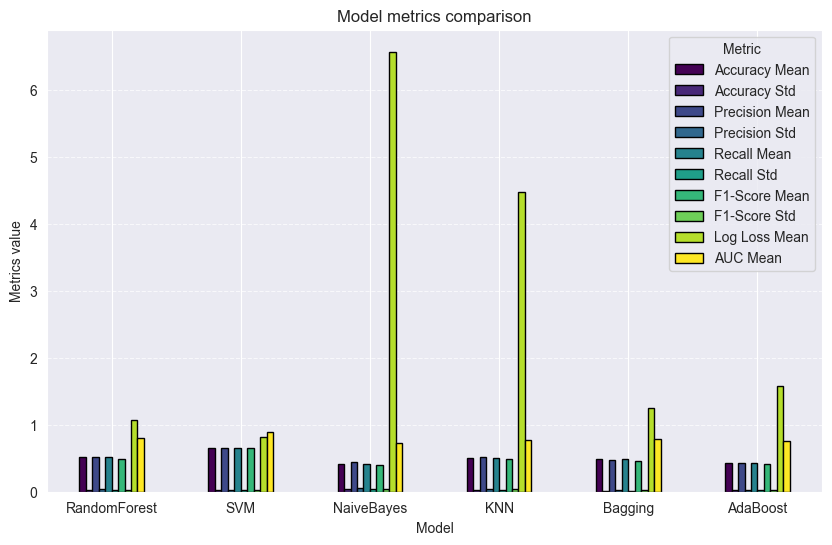

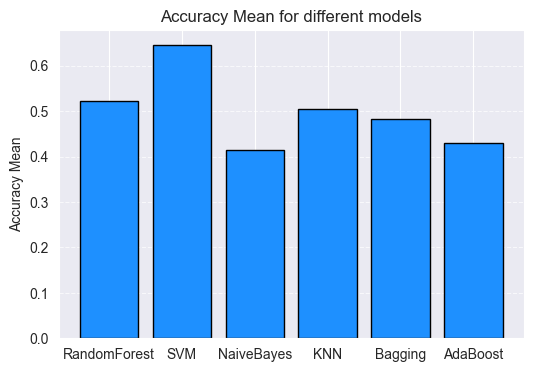

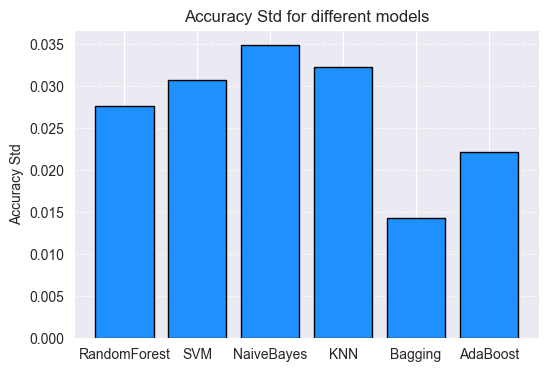

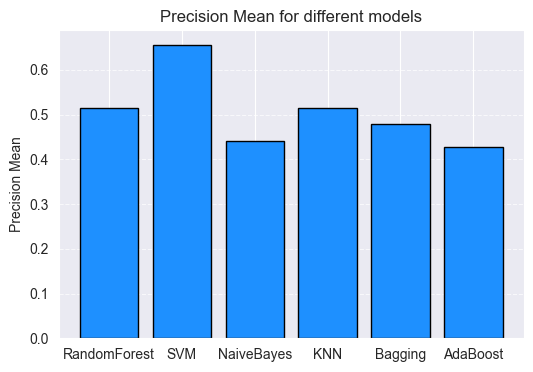

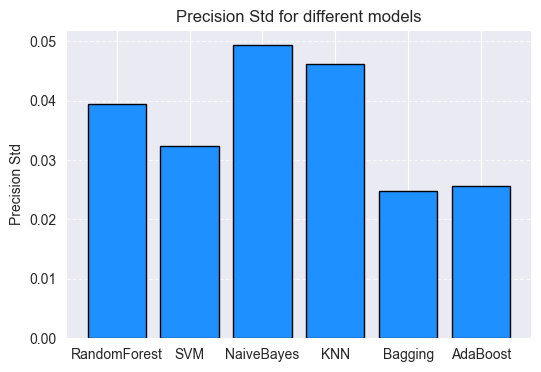

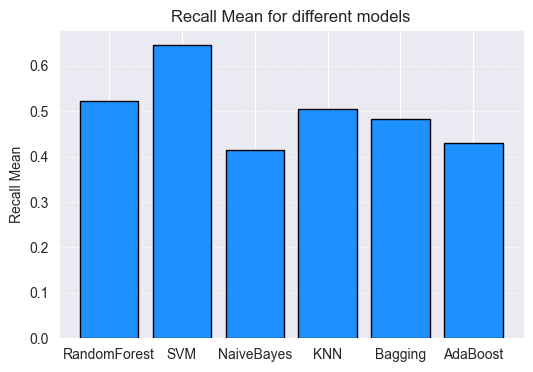

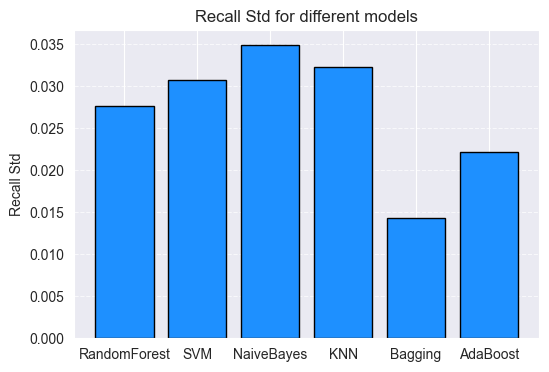

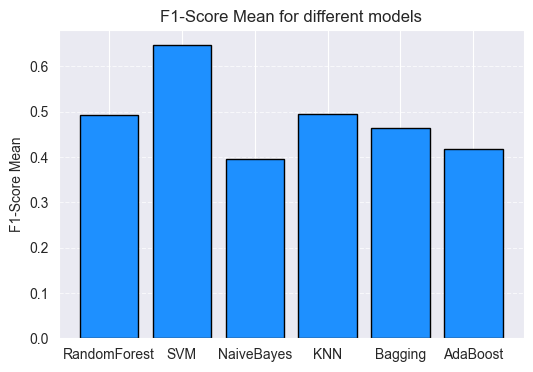

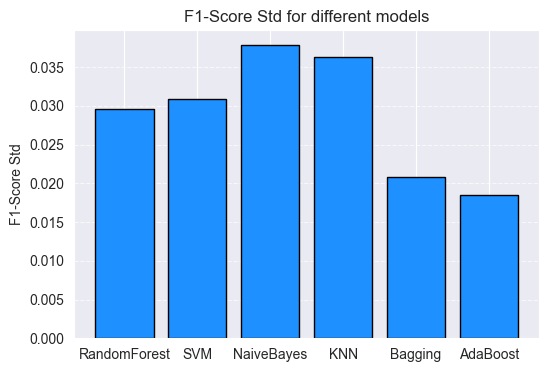

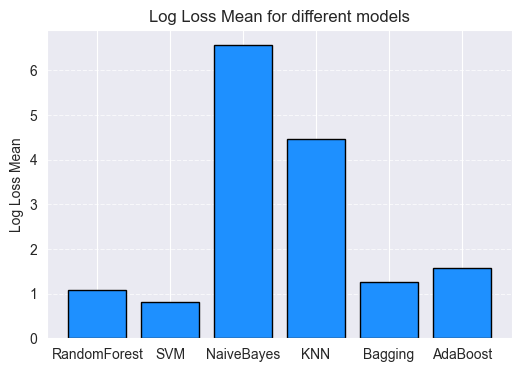

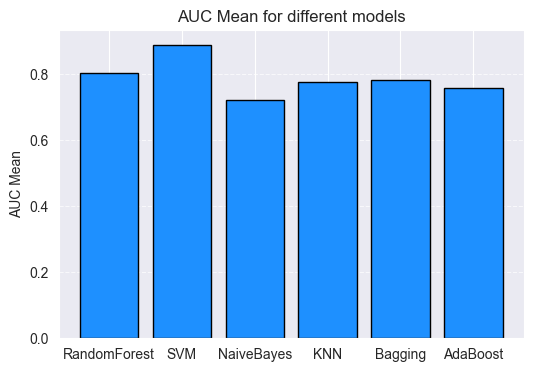

In [22]:
df_results.set_index("Model").plot(kind="bar", figsize=(10,6), colormap="viridis", edgecolor="black")
plt.title("Model metrics comparison")
plt.ylabel("Metrics value")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

for metric in df_results.columns[1:]:
    plt.figure(figsize=(6,4))
    plt.bar(df_results["Model"], df_results[metric], color="dodgerblue", edgecolor="black")
    plt.title(f"{metric} for different models")
    plt.ylabel(metric)
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

In [23]:
df_class_results

,Model,Class,Precision,Recall,F1-Score
0,RandomForest,0,0.420000,0.700000,0.525000
1,RandomForest,1,0.600000,0.400000,0.480000
2,RandomForest,2,0.416667,0.400000,0.408163
3,RandomForest,3,0.166667,0.050000,0.076923
4,RandomForest,4,1.000000,1.000000,1.000000
5,RandomForest,0,0.410000,0.683333,0.512500
6,RandomForest,1,0.656250,0.700000,0.677419
7,RandomForest,2,0.514286,0.360000,0.423529
8,RandomForest,3,0.307692,0.100000,0.150943
9,RandomForest,4,1.000000,1.000000,1.000000


Best model: SVM with F1-Score = 0.7000925869911571
Worst model: NaiveBayes with F1-Score = 0.44903914946313095


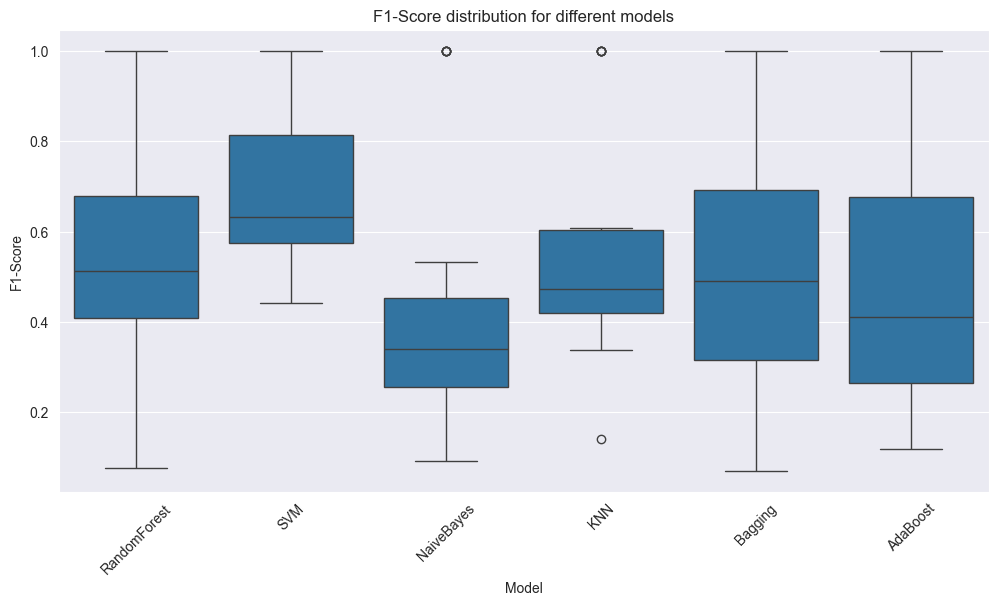

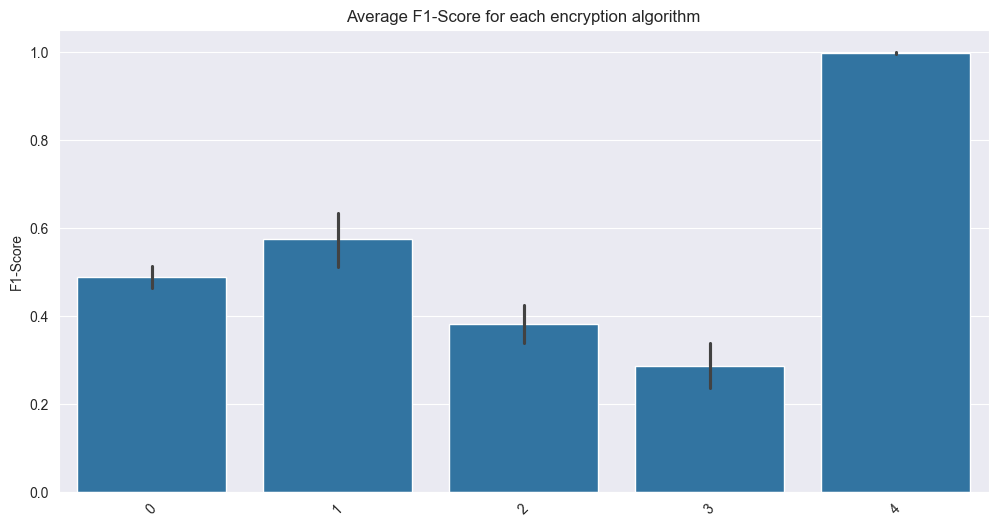

In [24]:
model_scores = df_class_results.groupby("Model")["F1-Score"].mean().sort_values(ascending=False)

best_model = model_scores.idxmax()
worst_model = model_scores.idxmin()
print(f"Best model: {best_model} with F1-Score = {model_scores.max()}")
print(f"Worst model: {worst_model} with F1-Score = {model_scores.min()}")

plt.figure(figsize=(12,6))
sns.boxplot(x="Model", y="F1-Score", data=df_class_results)
plt.xticks(rotation=45)
plt.title("F1-Score distribution for different models")
plt.ylabel("F1-Score")
plt.show()

class_scores = df_class_results.groupby("Class")["F1-Score"].mean().sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=encoder.classes_[df_class_results["Class"]], y="F1-Score", data=df_class_results)
plt.xticks(rotation=45)
plt.title("Average F1-Score for each encryption algorithm")
plt.ylabel("F1-Score")
plt.show()

Best model: SVM with F1-Score = 0.7000925869911571
Worst model: NaiveBayes with F1-Score = 0.44903914946313095


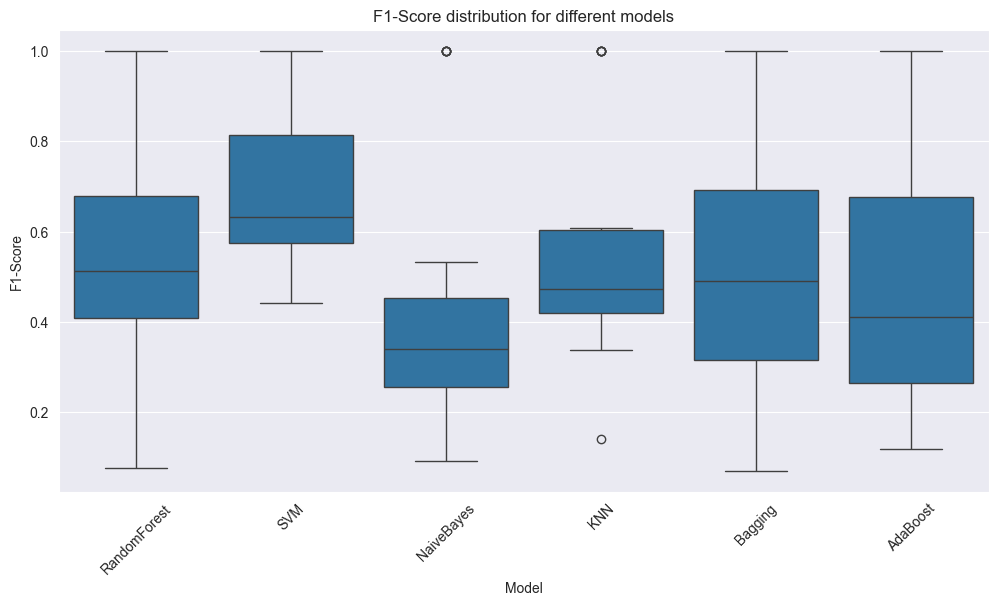

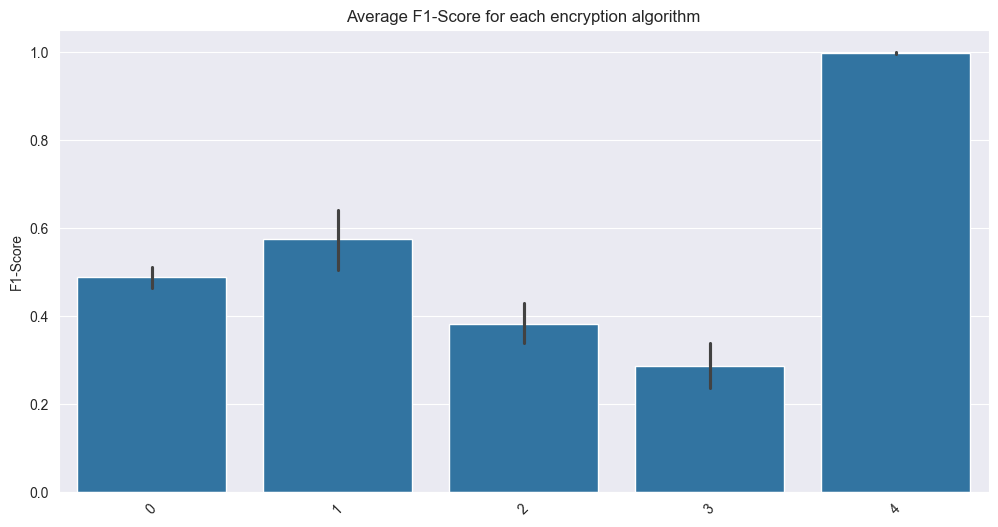

In [25]:
model_scores = df_class_results.groupby("Model")["F1-Score"].mean().sort_values(ascending=False)

best_model = model_scores.idxmax()
worst_model = model_scores.idxmin()
print(f"Best model: {best_model} with F1-Score = {model_scores.max()}")
print(f"Worst model: {worst_model} with F1-Score = {model_scores.min()}")

plt.figure(figsize=(12,6))
sns.boxplot(x="Model", y="F1-Score", data=df_class_results)
plt.xticks(rotation=45)
plt.title("F1-Score distribution for different models")
plt.ylabel("F1-Score")
plt.show()

class_scores = df_class_results.groupby("Class")["F1-Score"].mean().sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=encoder.classes_[df_class_results["Class"]], y="F1-Score", data=df_class_results)
plt.xticks(rotation=45)
plt.title("Average F1-Score for each encryption algorithm")
plt.ylabel("F1-Score")
plt.show()

In [1]:
import pandas as pd

data_frame = pd.read_csv('encrypted_features_txt_1000_ecb.csv')
data_frame

,file_name,entropy,mean,variance,std_dev,skewness,kurtosis,energy,rms,histogram_0,...,histogram_247,histogram_248,histogram_249,histogram_250,histogram_251,histogram_252,histogram_253,histogram_254,histogram_255,algorithm
0,file0359.txt.enc,7.976844,128.101334,5314.339758,72.899518,-0.013909,-1.170626,813877,10.315860,26,...,27,31,26,34,32,24,26,32,23,DES
1,file0349.txt.enc,7.955156,125.180851,5527.607718,74.347883,0.026588,-1.200481,390520,10.191256,20,...,11,12,13,15,14,12,13,12,13,DES
2,file0474.txt.enc,7.952942,127.240346,5606.797417,74.878551,-0.001756,-1.229536,411234,10.221555,15,...,9,9,12,13,23,24,15,15,20,DES
3,file0464.txt.enc,7.853888,127.697794,5366.093230,73.253623,0.032639,-1.169655,145371,10.338783,5,...,6,9,5,5,3,4,5,8,8,DES
4,file0416.txt.enc,7.975566,128.614079,5412.677394,73.570900,-0.015208,-1.205074,892243,10.291588,27,...,29,34,29,24,40,33,32,33,34,DES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,file0058.txt.enc,7.958384,126.755736,5504.073049,74.189440,0.006378,-1.212936,542725,10.360635,19,...,9,25,25,21,21,18,18,24,16,AES
996,file0256.txt.enc,7.947136,127.766628,5426.144506,73.662368,-0.005166,-1.182701,366838,10.255313,14,...,14,13,12,13,22,10,10,17,8,AES
997,file0246.txt.enc,7.940557,127.018076,5497.270200,74.143578,-0.001508,-1.230272,352381,10.390374,10,...,20,8,11,7,15,11,11,11,10,AES
998,file0189.txt.enc,7.852501,127.194522,5540.121571,74.431993,0.016029,-1.215906,150665,10.286111,7,...,5,3,10,7,5,7,8,2,3,AES


In [2]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data_frame['algorithm'] = encoder.fit_transform(data_frame['algorithm'])
print(encoder.classes_)

['AES' 'ARC4' 'DES' 'DES3' 'NONE']


In [3]:
from sklearn.preprocessing import MinMaxScaler

X = data_frame.drop(columns=["algorithm", "file_name"])
y = data_frame["algorithm"]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
import pandas as pd
import numpy as np
from itertools import product
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    log_loss, roc_auc_score
)

model_params = {
    "RandomForest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", "log2", None]  
    },
    "SVM": {
        "kernel": ["linear", "rbf", "poly", "sigmoid"],
        "C": [0.1, 1, 10],
        "gamma": ["scale", "auto"],
        "degree": [3, 4, 5],
        "coef0": [0, 0.1, 1]
    },
    "NaiveBayes": {
        "var_smoothing": [1e-9, 1e-8, 1e-7]
    },
    "KNN": {
        "n_neighbors": [3, 5, 7, 10],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan", "minkowski"]
    },
    "Bagging": {
        "n_estimators": [10, 50, 100],
        "max_samples": [0.5, 0.8, 1.0],
        "max_features": [0.5, 0.8, 1.0]
    },
    "AdaBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1.0]
    }
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_list = []
class_results = []

for model_name, param_grid in model_params.items():
    param_combinations = [dict(zip(param_grid.keys(), values)) for values in product(*param_grid.values())] or [{}]

    for params in param_combinations:
        if model_name == "RandomForest":
            model = RandomForestClassifier(**params, random_state=42)
        elif model_name == "SVM":
            model = SVC(**params, probability=True, random_state=42)
        elif model_name == "NaiveBayes":
            model = GaussianNB()
        elif model_name == "KNN":
            model = KNeighborsClassifier(**params)
        elif model_name == "Bagging":
            model = BaggingClassifier(**params, random_state=42)
        elif model_name == "AdaBoost":
            model = AdaBoostClassifier(**params, random_state=42)

        acc_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
        log_losses, auc_scores = [], []

        for train_index, test_index in skf.split(X_scaled, y):
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

            acc_scores.append(accuracy_score(y_test, y_pred))
            precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
            recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
            f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

            if y_pred_proba is not None:
                log_losses.append(log_loss(y_test, y_pred_proba))
                auc_scores.append(roc_auc_score(y_test, y_pred_proba, multi_class="ovr"))
            else:
                log_losses.append(None)
                auc_scores.append(None)

            class_precision = precision_score(y_test, y_pred, average=None)
            class_recall = recall_score(y_test, y_pred, average=None)
            class_f1 = f1_score(y_test, y_pred, average=None)

            for i, class_label in enumerate(np.unique(y)):
                class_results.append({
                    "Model": model_name,
                    "Params": str(params),
                    "Class": class_label,
                    "Precision": class_precision[i],
                    "Recall": class_recall[i],
                    "F1-Score": class_f1[i]
                })

        # Agregacja wyników ogólnych
        results_list.append({
            "Model": model_name,
            "Params": str(params),
            "Accuracy Mean": np.mean(acc_scores),
            "Accuracy Std": np.std(acc_scores),
            "Precision Mean": np.mean(precision_scores),
            "Precision Std": np.std(precision_scores),
            "Recall Mean": np.mean(recall_scores),
            "Recall Std": np.std(recall_scores),
            "F1-Score Mean": np.mean(f1_scores),
            "F1-Score Std": np.std(f1_scores),
            "Log Loss Mean": np.mean([x for x in log_losses if x is not None]) if any(log_losses) else None,
            "AUC Mean": np.mean([x for x in auc_scores if x is not None]) if any(auc_scores) else None
        })

df_results = pd.DataFrame(results_list)
df_class_results = pd.DataFrame(class_results)

df_results.to_csv("model_results.csv", index=False)
df_class_results.to_csv("class_results.csv", index=False)

df_results.style.format("{:.4f}"), df_class_results.style.format("{:.4f}")


/Users/jakubkowalewski/Desktop/Praca_magisterska/pythonProject1/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakubkowalewski/Desktop/Praca_magisterska/pythonProject1/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakubkowalewski/Desktop/Praca_magisterska/pythonProject1/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use 

(<pandas.io.formats.style.Styler at 0x16c2fa220>,
 <pandas.io.formats.style.Styler at 0x307980f70>)

In [5]:
df_results

,Model,Params,Accuracy Mean,Accuracy Std,Precision Mean,Precision Std,Recall Mean,Recall Std,F1-Score Mean,F1-Score Std,Log Loss Mean,AUC Mean
0,RandomForest,"{'n_estimators': 50, 'max_depth': None, 'min_s...",0.486,0.031209,0.488649,0.036937,0.486,0.031209,0.465394,0.035693,1.096204,0.786216
1,RandomForest,"{'n_estimators': 50, 'max_depth': None, 'min_s...",0.492,0.025417,0.496135,0.046455,0.492,0.025417,0.466448,0.038053,1.095996,0.794922
2,RandomForest,"{'n_estimators': 50, 'max_depth': None, 'min_s...",0.500,0.031780,0.504956,0.049096,0.500,0.031780,0.480477,0.038906,1.278485,0.786525
3,RandomForest,"{'n_estimators': 50, 'max_depth': None, 'min_s...",0.496,0.036797,0.497464,0.047197,0.496,0.036797,0.475832,0.040985,1.092351,0.789121
4,RandomForest,"{'n_estimators': 50, 'max_depth': None, 'min_s...",0.476,0.010198,0.496550,0.018842,0.476,0.010198,0.460774,0.013038,1.109445,0.785934
...,...,...,...,...,...,...,...,...,...,...,...,...
382,AdaBoost,"{'n_estimators': 100, 'learning_rate': 0.1}",0.462,0.023791,0.374373,0.029072,0.462,0.023791,0.377774,0.024979,1.569098,0.745029
383,AdaBoost,"{'n_estimators': 100, 'learning_rate': 1.0}",0.460,0.043932,0.464260,0.042785,0.460,0.043932,0.449252,0.044180,1.586690,0.770147
384,AdaBoost,"{'n_estimators': 200, 'learning_rate': 0.01}",0.400,0.000000,0.200000,0.000000,0.400,0.000000,0.250000,0.000000,1.560750,0.692922
385,AdaBoost,"{'n_estimators': 200, 'learning_rate': 0.1}",0.473,0.031718,0.409280,0.052924,0.473,0.031718,0.402637,0.020960,1.576107,0.755091


In [2]:
import tensorflow as tf
from keras.api.models import Sequential
from keras.api.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import pandas as pd

df = pd.read_csv('encrypted_features_txt_1000_ecb.csv')
df

,file_name,entropy,mean,variance,std_dev,skewness,kurtosis,energy,rms,histogram_0,...,histogram_247,histogram_248,histogram_249,histogram_250,histogram_251,histogram_252,histogram_253,histogram_254,histogram_255,algorithm
0,file0359.txt.enc,7.976844,128.101334,5314.339758,72.899518,-0.013909,-1.170626,813877,10.315860,26,...,27,31,26,34,32,24,26,32,23,DES
1,file0349.txt.enc,7.955156,125.180851,5527.607718,74.347883,0.026588,-1.200481,390520,10.191256,20,...,11,12,13,15,14,12,13,12,13,DES
2,file0474.txt.enc,7.952942,127.240346,5606.797417,74.878551,-0.001756,-1.229536,411234,10.221555,15,...,9,9,12,13,23,24,15,15,20,DES
3,file0464.txt.enc,7.853888,127.697794,5366.093230,73.253623,0.032639,-1.169655,145371,10.338783,5,...,6,9,5,5,3,4,5,8,8,DES
4,file0416.txt.enc,7.975566,128.614079,5412.677394,73.570900,-0.015208,-1.205074,892243,10.291588,27,...,29,34,29,24,40,33,32,33,34,DES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,file0058.txt.enc,7.958384,126.755736,5504.073049,74.189440,0.006378,-1.212936,542725,10.360635,19,...,9,25,25,21,21,18,18,24,16,AES
996,file0256.txt.enc,7.947136,127.766628,5426.144506,73.662368,-0.005166,-1.182701,366838,10.255313,14,...,14,13,12,13,22,10,10,17,8,AES
997,file0246.txt.enc,7.940557,127.018076,5497.270200,74.143578,-0.001508,-1.230272,352381,10.390374,10,...,20,8,11,7,15,11,11,11,10,AES
998,file0189.txt.enc,7.852501,127.194522,5540.121571,74.431993,0.016029,-1.215906,150665,10.286111,7,...,5,3,10,7,5,7,8,2,3,AES


In [3]:
X = df.drop(["file_name", "algorithm"], axis=1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

le = LabelEncoder()
y = le.fit_transform(df["algorithm"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(le.classes_), activation='softmax'))

model.summary()

/home/kevvol/projects/praca_magisterska/pythonProject/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744648488.154040    8445 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13291 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        33,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,501 (166.02 KB)

 Trainable params: 42,501 (166.02 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.4763 - loss: 1.0621 - val_accuracy: 0.4750 - val_loss: 1.0240
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5452 - loss: 0.9900 - val_accuracy: 0.6000 - val_loss: 0.9586
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5650 - loss: 0.9628 - val_accuracy: 0.4625 - val_loss: 0.9870
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5512 - loss: 0.9504 - val_accuracy: 0.5875 - val_loss: 0.9168
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5857 - loss: 0.9582 - val_accuracy: 0.7125 - val_loss: 0.8967
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6060 - loss: 0.9099 - val_accuracy: 0.5250 - val_loss: 0.9078
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6197 - loss: 0.8636 - val_accuracy: 0.6500 - val_loss: 0.8898
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6546 - loss: 0.8350 - val_accuracy: 0.7125 - 